# Import

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset,DataLoader,Subset
from PIL import Image,ImageOps,ImageEnhance

import cv2
import albumentations as A
from albumentations.pytorch import ToTensor

import glob
import xml.etree.ElementTree as ET #for parsing XML
import shutil
from tqdm import tqdm
import time
import random
import os
from tqdm import tqdm_notebook


from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    PadIfNeeded,
    Compose
)

In [2]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Variables

In [3]:
ORIGIN_IMAGES_PATH = 'data/motobike'
OUTPUT_IMAGES_PATH = 'data/resized128_image'

# Data loader

In [4]:
data_list = os.listdir(ORIGIN_IMAGES_PATH)
data_path = ORIGIN_IMAGES_PATH

In [5]:
len(data_list)

10373

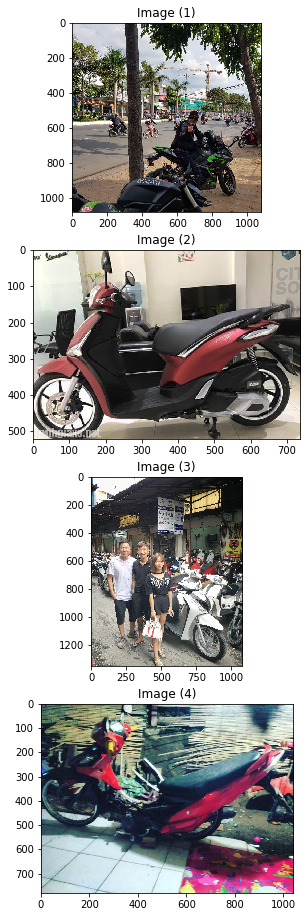

In [6]:
np.random.shuffle(data_list)
sample_images = [plt.imread(os.path.join(data_path, data_list[i])) for i in range(4)]
show_images(sample_images, cols=4)

In [7]:
fname = data_list[random.randint(0, len(data_list))]

In [8]:
def crop_image(data_path, fname):
    path = os.path.join(data_path, fname)
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_size = image.shape[:2]

    preprocess = Compose([
        PadIfNeeded(min_width=256, min_height=256),
    #     CenterCrop(width=min(image_size), height=min(image_size)),
        Resize(150, 150, interpolation=cv2.INTER_AREA),
        CenterCrop(width=128, height=128, p=1.0)
    ])
    image = preprocess(image=image)['image']
    return image

In [9]:
np.random.shuffle(data_list)
input_list = data_list[:10]

result_image = []
for fname in input_list:
    try:
        image = crop_image(data_path, fname)
        result_image.append(image)
    except:
        pass

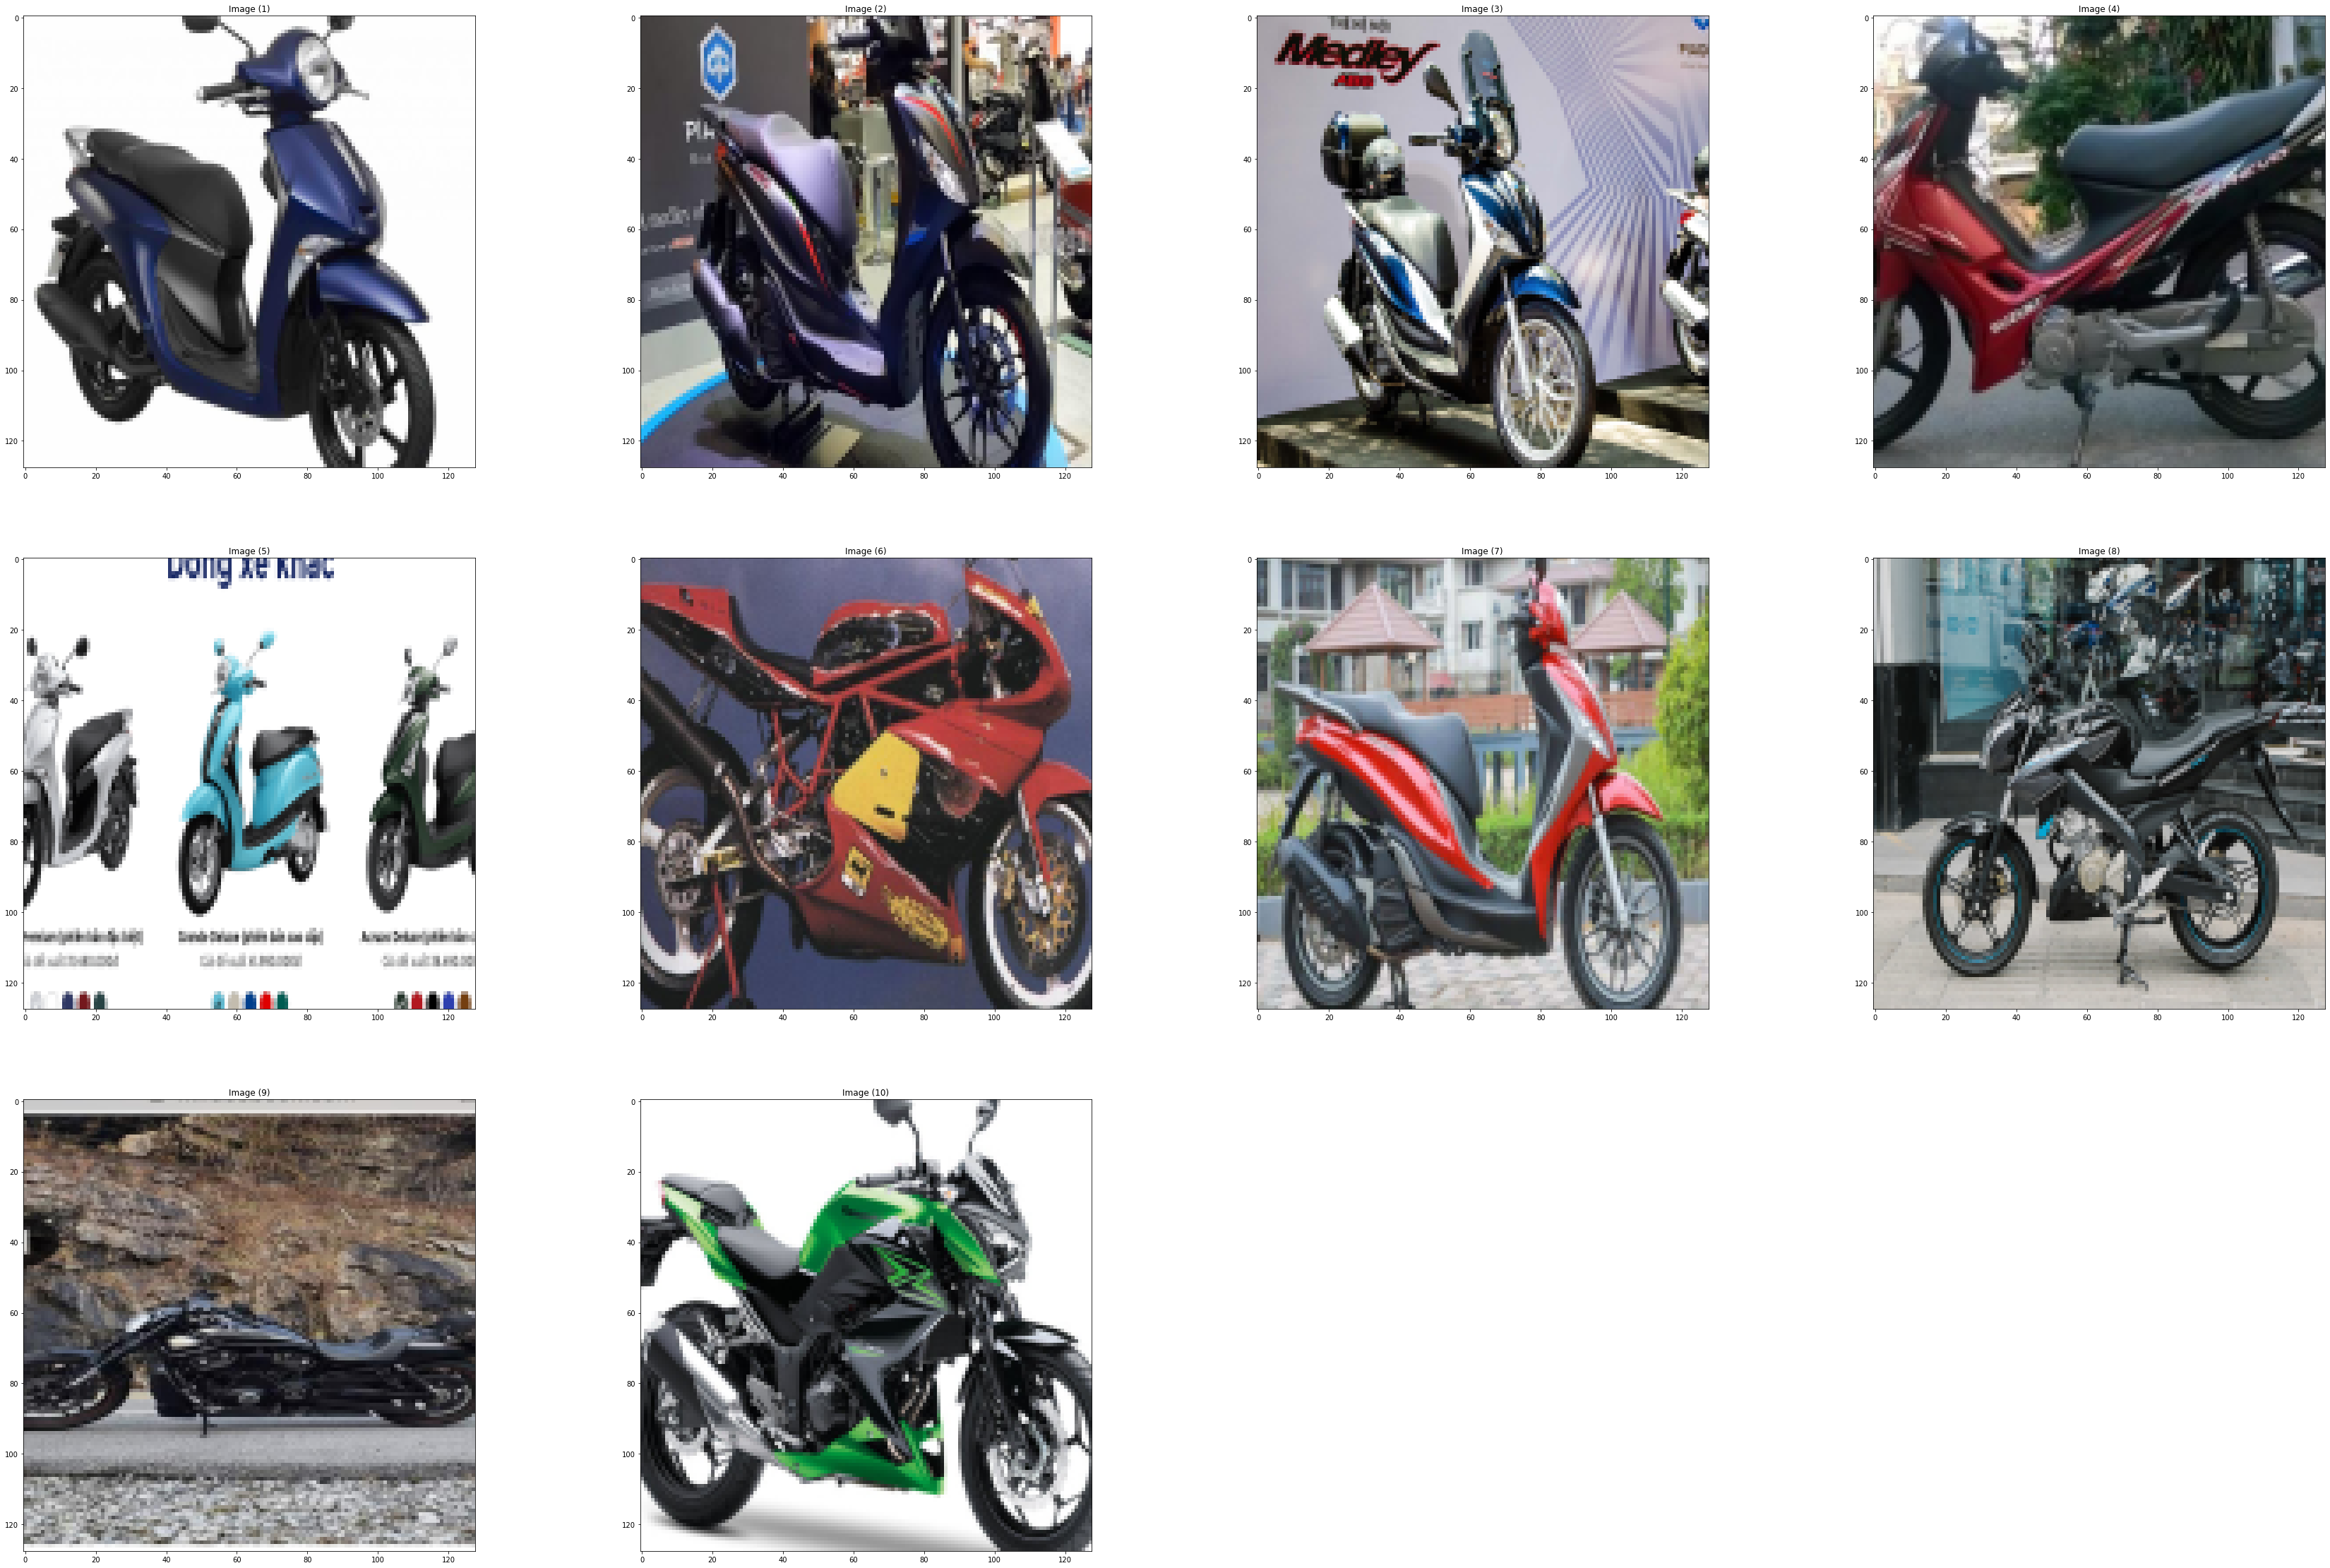

In [10]:
show_images(result_image, cols=3)

In [11]:
!rm -rf {OUTPUT_IMAGES_PATH}
!mkdir {OUTPUT_IMAGES_PATH}

In [12]:
out_dir = OUTPUT_IMAGES_PATH

In [15]:
for fname in tqdm_notebook(data_list):
    try:
        image = crop_image(data_path, fname)
        out_path = os.path.join(out_dir, fname)
        cv2.imwrite(out_path, image)
    except:
        print("Keep ", fname)
        pass

Keep  19_r_636858959614681208_4528_kkk_1568719429934_12092.gif
Keep  69_xedoisong_Yamaha_MT_03_do_1_MEGC_1568719472292_12693.gif
Keep  65_51ew43mofl9ef_1568719232558_9326.gif
Keep  Motorheiow5b5smallMotor.jpg
Keep  cqtqdo_VRF_750_800_for_new_rider__hd93yl7kong31_1568720006698_20021.gif
Keep  55_gia_xe_81_2_1568719088201_7338.gif
Keep  80_motorcycle_application1_1568719028982_6503.gif
Keep  24_kawasaki_vulcan_s_abs_2016_moto_saigon_3_1568719119960_7778.gif
Keep  29_pic_001_1568719608045_14577.gif



# Define dataset

In [16]:
# generate 64x64 images!
#resize_size = 84
img_size    = 64
NUM_WORKERS = 1
batch_size  = 32

mean = 0.5, 0.5, 0.5
std = 0.5, 0.5, 0.5

transform1 = transforms.Compose([transforms.Resize(img_size)])
#transform1 = transforms.Compose([transforms.Resize((resize_size,resize_size))])

transform2 = transforms.Compose([transforms.RandomCrop(img_size),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std),
                                ])

In [21]:
class MotorbikeDataset(Dataset):
    def __init__(self, path, img_list, transform1=None, transform2=None):
        self.path      = path
        self.img_list  = img_list
        self.transform1 = transform1
        self.transform2 = transform2
        self.load_data(img_list)

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img = self.images[idx]
        if self.transform2:
            img = self.transform2(img)
        return img
    
    def load_data(self, img_list):
        self.images = []
        for idx, path in enumerate(img_list):
            img = Image.open(os.path.join(self.path, self.img_list[idx]))
            img = self.transform1(img)
            self.images.append(img)
        return self.images

In [23]:
img_list = os.listdir(OUTPUT_IMAGES_PATH)
dataset = MotorbikeDataset(OUTPUT_IMAGES_PATH, img_list, transform1, transform2)

In [24]:
%%timeit
dataset[0]

224 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
train_loader = DataLoader(dataset,
                          shuffle=True, 
                          batch_size=batch_size,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [26]:
import shutil
output_filename = 'preprocess'
dir_name = 'data/resized128_image'
shutil.make_archive(output_filename, 'zip', dir_name)

'/Users/admin/ZaloAi/motorbike-generator/preprocess.zip'